<a href="https://colab.research.google.com/github/ReynadelYolo/ML_Projects/blob/main/Chatbot_Analytics_V1_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets sweetviz

from datasets import load_dataset


dataset = load_dataset("electricsheepafrica/nigerian-telecom-chatbot-and-live-chat-logs")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['session_id', 'session_start', 'session_end', 'duration_seconds', 'customer_id', 'operator', 'channel', 'intent', 'handled_by', 'escalated_to_human', 'message_count', 'resolved', 'customer_satisfaction', 'language'],
        num_rows: 400000
    })
})


In [3]:
import pandas as pd

# Convert the 'train' split to a Pandas DataFrame
df = dataset['train'].to_pandas()

# Display the first few rows
df.head()

,session_id,session_start,session_end,duration_seconds,customer_id,operator,channel,intent,handled_by,escalated_to_human,message_count,resolved,customer_satisfaction,language
0,CHAT00000001,2025-09-16 06:01:00,2025-09-16 06:02:47,107,CUST5465481,MTN,whatsapp,port_number,bot,False,14,True,5,english
1,CHAT00000002,2025-09-03 00:38:00,2025-09-03 00:42:49,289,CUST7117483,Airtel,app,port_number,bot,False,21,True,5,english
2,CHAT00000003,2025-09-09 01:23:00,2025-09-09 01:36:55,835,CUST4948915,MTN,app,port_number,human,True,6,True,3,english
3,CHAT00000004,2025-09-04 11:21:00,2025-09-04 11:33:36,756,CUST1858299,MTN,app,recharge_issue,human,True,25,True,4,english
4,CHAT00000005,2025-09-13 03:09:00,2025-09-13 03:11:11,131,CUST8344247,Airtel,web,port_number,bot,False,18,True,1,pidgin


In [4]:
# Access the first row
print(dataset['train'][0])

# Access a specific column
print(dataset['train']['language'][:5])

{'session_id': 'CHAT00000001', 'session_start': Timestamp('2025-09-16 06:01:00'), 'session_end': Timestamp('2025-09-16 06:02:47'), 'duration_seconds': 107, 'customer_id': 'CUST5465481', 'operator': 'MTN', 'channel': 'whatsapp', 'intent': 'port_number', 'handled_by': 'bot', 'escalated_to_human': False, 'message_count': 14, 'resolved': True, 'customer_satisfaction': 5, 'language': 'english'}
['english', 'english', 'english', 'english', 'pidgin']


In [5]:
print(f"Dataset Shape: {df.shape}")
df.info() # Check for nulls and data types

Dataset Shape: (400000, 14)
<class 'pandas.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   session_id             400000 non-null  str           
 1   session_start          400000 non-null  datetime64[ns]
 2   session_end            400000 non-null  datetime64[ns]
 3   duration_seconds       400000 non-null  int64         
 4   customer_id            400000 non-null  str           
 5   operator               400000 non-null  str           
 6   channel                400000 non-null  str           
 7   intent                 400000 non-null  str           
 8   handled_by             400000 non-null  str           
 9   escalated_to_human     400000 non-null  bool          
 10  message_count          400000 non-null  int64         
 11  resolved               400000 non-null  bool          
 12  customer_satisfaction  4000

In [6]:
# =============================================================================
# CELL 5: SYNTHETIC DATA ADDITION
# =============================================================================

import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1. SEX
df['sex'] = df['session_id'].apply(lambda x: 'Male' if hash(x) % 2 == 0 else 'Female')

# 2. AGE
def assign_age(session_id):
    np.random.seed(hash(session_id + 'age') % 10000)
    return min(max(int(np.random.beta(2, 5) * 47 + 18), 18), 65)
df['age'] = df['session_id'].apply(assign_age)

# 3. ZONE
zone_weights = {'South West': 0.28, 'North West': 0.22, 'North Central': 0.16,
                'South South': 0.14, 'South East': 0.12, 'North East': 0.08}
def assign_zone(session_id):
    np.random.seed(hash(session_id + 'zone') % 10000)
    return np.random.choice(list(zone_weights.keys()), p=list(zone_weights.values()))
df['zone'] = df['session_id'].apply(assign_zone)

# 4. MONTH
month_weights = [0.09, 0.07, 0.08, 0.08, 0.08, 0.07, 0.08, 0.08, 0.08, 0.09, 0.09, 0.11]
def assign_month(session_id):
    np.random.seed(hash(session_id + 'month') % 10000)
    return np.random.choice(range(1, 13), p=month_weights)
df['month'] = df['session_id'].apply(assign_month)

# 5. ESCALATION (~8.5%)
intent_escalation_rates = {
    'check_balance': 0.02, 'check_data_balance': 0.03, 'tariff_info': 0.04,
    'buy_data': 0.05, 'general_inquiry': 0.06, 'bill_inquiry': 0.08,
    'recharge_issue': 0.12, 'port_number': 0.15, 'network_issue': 0.18, 'complaint': 0.22
}

def assign_escalation(row):
    base_rate = intent_escalation_rates.get(row['intent'], 0.05)
    if row['duration_seconds'] > 600:
        base_rate += 0.05
    np.random.seed(hash(row['session_id'] + 'escalation') % 10000)
    return np.random.random() < base_rate

df['escalated_to_human'] = df.apply(assign_escalation, axis=1)

# 6. DIRECT HUMAN ROUTING (separate from escalation)
direct_human_rates = {
    'check_balance': 0.05, 'check_data_balance': 0.08, 'tariff_info': 0.10,
    'buy_data': 0.12, 'general_inquiry': 0.15, 'bill_inquiry': 0.25,
    'recharge_issue': 0.35, 'port_number': 0.45, 'network_issue': 0.40, 'complaint': 0.50
}

def assign_direct_human(row):
    if row['escalated_to_human']:
        return False  # Not direct - it's escalation
    np.random.seed(hash(row['session_id'] + 'direct_human') % 10000)
    return np.random.random() < direct_human_rates.get(row['intent'], 0.10)

df['direct_to_human'] = df.apply(assign_direct_human, axis=1)

# 7. FINAL HANDLED_BY
df['handled_by'] = df.apply(
    lambda row: 'human' if row['escalated_to_human'] or row['direct_to_human'] else 'bot',
    axis=1
)

# VERIFICATION
print(f"""
📊 ROUTING SUMMARY:
Escalated to Human: {df['escalated_to_human'].sum():,} ({df['escalated_to_human'].mean()*100:.1f}%)
Direct to Human: {df['direct_to_human'].sum():,} ({df['direct_to_human'].mean()*100:.1f}%)
Total Human: {(df['handled_by']=='human').sum():,} ({(df['handled_by']=='human').mean()*100:.1f}%)
Bot Handled: {(df['handled_by']=='bot').sum():,} ({(df['handled_by']=='bot').mean()*100:.1f}%)
""")

# 8. CONVERSATION TEXT & SENTIMENT
conversation_templates = {
    'check_balance': [("How do I check my balance?", "neutral"), ("What's my balance?", "neutral")],
    'check_data_balance': [("How much data do I have left?", "neutral"), ("Check my data balance", "neutral")],
    'tariff_info': [("What are your tariff plans?", "neutral"), ("Tell me about call rates", "neutral")],
    'buy_data': [("I want to buy data", "neutral"), ("Data purchase please", "neutral"), ("Data finished too fast!", "negative")],
    'general_inquiry': [("I have a question", "neutral"), ("Can you help me?", "neutral"), ("Thanks for the help!", "positive")],
    'bill_inquiry': [("Explain my bill please", "neutral"), ("Why is my bill so high?", "negative"), ("Charges unclear", "negative")],
    'recharge_issue': [("Recharge not working", "negative"), ("My recharge failed!", "negative"), ("Money deducted but no credit", "negative")],
    'port_number': [("I want to port my number", "neutral"), ("How to transfer to another network?", "neutral")],
    'network_issue': [("No network in my area", "negative"), ("Calls keep dropping", "negative"), ("Network very poor!", "negative")],
    'complaint': [("I have a complaint", "negative"), ("Service is terrible!", "negative"), ("Very disappointed", "negative")]
}
def generate_conversation(row):
    np.random.seed(hash(row['session_id'] + 'conv') % 10000)
    templates = conversation_templates.get(row['intent'], [("General inquiry", "neutral")])
    return templates[np.random.randint(0, len(templates))]
conv_data = df.apply(generate_conversation, axis=1)
df['conversation_text'] = conv_data.apply(lambda x: x[0])
df['sentiment'] = conv_data.apply(lambda x: x[1])

# VERIFICATION
print(f"Shape: {df.shape}")
print(f"Escalation Rate: {df['escalated_to_human'].mean()*100:.2f}%")
print(f"Human Rate: {(df['handled_by'] == 'human').mean()*100:.2f}%")
print(f"Sentiment:\n{df['sentiment'].value_counts(normalize=True).round(3)}")


📊 ROUTING SUMMARY:
Escalated to Human: 45,923 (11.5%)
Direct to Human: 83,219 (20.8%)
Total Human: 129,142 (32.3%)
Bot Handled: 270,858 (67.7%)

Shape: (400000, 21)
Escalation Rate: 11.48%
Human Rate: 32.29%
Sentiment:
sentiment
neutral     0.568
negative    0.399
positive    0.033
Name: proportion, dtype: float64


In [7]:
# =============================================================================
# CELL 6: FEATURE ENGINEERING
# =============================================================================
# Input: 22 columns (14 original + 8 synthetic)
# Output: +18 engineered features

# ----- TIME FEATURES -----
df['response_latency'] = df['duration_seconds'] / df['message_count']
df['hour'] = df['session_start'].dt.hour
df['day_of_week'] = df['session_start'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_peak_hour'] = df['hour'].isin([9,10,11,12,13,17,18,19]).astype(int)
df['time_period'] = pd.cut(df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True)

# ----- USER BEHAVIOR FEATURES -----
df['session_count'] = df.groupby('customer_id')['session_id'].transform('count')
df['is_recurring_user'] = (df['session_count'] > 1).astype(int)
df['is_long_session'] = (df['duration_seconds'] > df['duration_seconds'].quantile(0.75)).astype(int)

# ----- CONVERSATION TEXT FEATURES -----
df['conversation_length'] = df['conversation_text'].str.len()
df['word_count'] = df['conversation_text'].str.split().str.len()

# ----- SENTIMENT FEATURES -----
df['is_negative_sentiment'] = (df['sentiment'] == 'negative').astype(int)
df['is_positive_sentiment'] = (df['sentiment'] == 'positive').astype(int)

# ----- CATEGORICAL FEATURES -----
df['satisfaction_tier'] = pd.cut(df['customer_satisfaction'],
    bins=[0, 2, 3, 5], labels=['Detractor', 'Passive', 'Promoter'])

df['age_group'] = pd.cut(df['age'],
    bins=[18, 25, 35, 45, 55, 65],
    labels=['18-25', '26-35', '36-45', '46-55', '56-65'],
    include_lowest=True)

# ----- AGGREGATED METRICS (SYNTHETIC DATA) -----
df['intent_complexity'] = df.groupby('intent')['escalated_to_human'].transform('mean')
df['zone_avg_csat'] = df.groupby('zone')['customer_satisfaction'].transform('mean')
df['month_session_volume'] = df.groupby('month')['session_id'].transform('count')
df['intent_negative_rate'] = df.groupby('intent')['is_negative_sentiment'].transform('mean')
df['operator_escalation_rate'] = df.groupby('operator')['escalated_to_human'].transform('mean')

# NOTE: Resolution-based aggregates calculated in Cell 7 (Adjustments) using adjusted_resolved

# ==================== VERIFICATION ====================
print(f"Total columns: {df.shape[1]}")
print(f"\nSentiment Distribution:\n{df['sentiment'].value_counts(normalize=True).round(3)}")
print(f"\nAge Group:\n{df['age_group'].value_counts()}")
print(f"Age Group NaN: {df['age_group'].isna().sum()}")
print(f"\nIntent Complexity (Escalation Rate):\n{df.groupby('intent')['escalated_to_human'].mean().sort_values(ascending=False).round(3)}")

Total columns: 41

Sentiment Distribution:
sentiment
neutral     0.568
negative    0.399
positive    0.033
Name: proportion, dtype: float64

Age Group:
age_group
26-35    189235
18-25    107078
36-45     86259
46-55     16809
56-65       619
Name: count, dtype: int64
Age Group NaN: 0

Intent Complexity (Escalation Rate):
intent
complaint             0.241
network_issue         0.201
port_number           0.172
recharge_issue        0.139
bill_inquiry          0.100
general_inquiry       0.080
buy_data              0.070
tariff_info           0.058
check_data_balance    0.046
check_balance         0.040
Name: escalated_to_human, dtype: float64


In [8]:
# =============================================================================
# CELL 7: DATA ADJUSTMENTS
# =============================================================================

import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1. ADJUSTED RESOLUTION (ORIGINAL 10 intents)
intent_resolution_profiles = {
    'check_balance': 0.95, 'check_data_balance': 0.93, 'tariff_info': 0.92,
    'buy_data': 0.88, 'general_inquiry': 0.85, 'bill_inquiry': 0.78,
    'recharge_issue': 0.72, 'port_number': 0.68, 'network_issue': 0.62, 'complaint': 0.55
}
operator_bonus = {'MTN': 0.05, 'Airtel': 0.02, 'Glo': 0.0, '9mobile': -0.05}

def calc_adjusted_resolved(row):
    np.random.seed(RANDOM_SEED + hash(row['session_id']) % 10000)
    base = intent_resolution_profiles.get(row['intent'], 0.70)
    threshold = base + operator_bonus.get(row['operator'], 0)
    return np.random.random() < threshold
df['adjusted_resolved'] = df.apply(calc_adjusted_resolved, axis=1)

# 2. ADJUSTED ESCALATION
def calc_adjusted_escalation(row):
    # Already escalated from bot → True
    if row['escalated_to_human']:
        return True

    # Direct to human from start → NOT escalation (handled separately)
    if row['direct_to_human']:
        return False

    # Bot handled but unresolved → 20% chance of late escalation
    if not row['adjusted_resolved']:
        np.random.seed(RANDOM_SEED + hash(row['session_id']) % 10000 + 2)
        return np.random.random() < 0.20

    return False

df['adjusted_escalated'] = df.apply(calc_adjusted_escalation, axis=1)

# 3. ADJUSTED HANDLED_BY (updated to match)
df['adjusted_handled_by'] = df.apply(
    lambda row: 'human' if row['adjusted_escalated'] or row['direct_to_human'] else 'bot',
    axis=1
)

# 4. ADJUSTED CSAT
operator_profiles = {'MTN': 0.3, 'Airtel': 0.1, 'Glo': -0.1, '9mobile': -0.2}
def adjust_csat(row):
    np.random.seed(RANDOM_SEED + hash(row['session_id']) % 10000)
    adjusted = row['customer_satisfaction'] + operator_profiles.get(row['operator'], 0) + np.random.normal(0, 0.3)
    if row['adjusted_resolved']: adjusted += 0.5
    if row['adjusted_escalated']: adjusted -= 0.2
    if row['sentiment'] == 'negative': adjusted -= 0.3
    elif row['sentiment'] == 'positive': adjusted += 0.2
    return int(np.clip(round(adjusted), 1, 5))
df['adjusted_csat'] = df.apply(adjust_csat, axis=1)

# 5. COMPLETION RATE
df['completion_rate'] = df['adjusted_resolved'].astype(int)

# 6. DEPENDENT FEATURES
df['adj_operator_resolution_rate'] = df.groupby('operator')['adjusted_resolved'].transform('mean')
df['adj_channel_resolution_rate'] = df.groupby('channel')['adjusted_resolved'].transform('mean')
df['adj_zone_resolution_rate'] = df.groupby('zone')['adjusted_resolved'].transform('mean')
df['adjusted_satisfaction_tier'] = pd.cut(df['adjusted_csat'], bins=[0,2,3,5], labels=['Detractor','Passive','Promoter'])
df['adj_bot_handled'] = (df['adjusted_handled_by'] == 'bot').astype(int)
df['adj_bot_resolved'] = ((df['adjusted_handled_by'] == 'bot') & df['adjusted_resolved']).astype(int)

df['bot_abandoned'] = ((df['adjusted_handled_by'] == 'bot') & ~df['adjusted_resolved']).astype(int)
df['human_via_escalation'] = df['adjusted_escalated'].astype(int)
df['human_via_direct'] = (df['direct_to_human'] & ~df['adjusted_escalated']).astype(int)
df['human_resolved'] = ((df['adjusted_handled_by'] == 'human') & df['adjusted_resolved']).astype(int)
df['human_unresolved'] = ((df['adjusted_handled_by'] == 'human') & ~df['adjusted_resolved']).astype(int)


# VERIFICATION
print("Resolution by Intent:")
print(df.groupby('intent')['adjusted_resolved'].mean().sort_values(ascending=False).round(3))

print(f"""
📊 SESSION FLOW:
Bot: {df['adj_bot_handled'].sum():,} (Resolved: {df['adj_bot_resolved'].sum():,} | Abandoned: {df['bot_abandoned'].sum():,})
Human: {(df['adjusted_handled_by']=='human').sum():,} (Escalated: {df['human_via_escalation'].sum():,} | Direct: {df['human_via_direct'].sum():,})
Total: {len(df):,} ✓
""")

Resolution by Intent:
intent
check_balance         0.971
check_data_balance    0.947
tariff_info           0.941
buy_data              0.900
general_inquiry       0.868
bill_inquiry          0.797
recharge_issue        0.737
port_number           0.697
network_issue         0.632
complaint             0.569
Name: adjusted_resolved, dtype: float64

📊 SESSION FLOW:
Bot: 262,897 (Resolved: 228,117 | Abandoned: 34,780)
Human: 137,103 (Escalated: 53,884 | Direct: 83,219)
Total: 400,000 ✓



In [9]:
# =============================================================================
# CELL 8: CHATBOT ANALYTICS - PLOTLY VISUALIZATIONS
# =============================================================================

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. RESOLUTION & CSAT BY INTENT ---
fig1 = make_subplots(rows=1, cols=2, subplot_titles=('Resolution Rate by Intent', 'Avg CSAT by Intent'))

intent_res = df.groupby('intent')['adjusted_resolved'].mean().sort_values(ascending=True).reset_index()
intent_csat = df.groupby('intent')['adjusted_csat'].mean().sort_values(ascending=True).reset_index()

fig1.add_trace(go.Bar(x=intent_res['adjusted_resolved'], y=intent_res['intent'], orientation='h', marker_color='steelblue'), row=1, col=1)
fig1.add_trace(go.Bar(x=intent_csat['adjusted_csat'], y=intent_csat['intent'], orientation='h', marker_color='seagreen'), row=1, col=2)
fig1.update_layout(height=400, showlegend=False, title_text="Intent Performance")
fig1.show()

# --- 2. OPERATOR COMPARISON ---
op_metrics = df.groupby('operator').agg({
    'adjusted_resolved': 'mean',
    'adjusted_csat': 'mean',
    'adjusted_escalated': 'mean'
}).round(3).reset_index()

fig2 = px.bar(op_metrics.melt(id_vars='operator'), x='operator', y='value', color='variable',
              barmode='group', title='Operator Performance Comparison',
              labels={'value': 'Rate/Score', 'variable': 'Metric'})
fig2.show()

# --- 3. CONVERSATION FUNNEL (Sankey) ---
total = len(df)
bot_handled = (df['adjusted_handled_by'] == 'bot').sum()
human_handled = (df['adjusted_handled_by'] == 'human').sum()
bot_resolved = df['adj_bot_resolved'].sum()
bot_unresolved = bot_handled - bot_resolved
human_resolved = ((df['adjusted_handled_by'] == 'human') & df['adjusted_resolved']).sum()
human_unresolved = human_handled - human_resolved

fig3 = go.Figure(go.Sankey(
    node=dict(label=['All Sessions', 'Bot', 'Human', 'Bot Resolved', 'Bot Unresolved', 'Human Resolved', 'Human Unresolved']),
    link=dict(
        source=[0, 0, 1, 1, 2, 2],
        target=[1, 2, 3, 4, 5, 6],
        value=[bot_handled, human_handled, bot_resolved, bot_unresolved, human_resolved, human_unresolved]
    )
))
fig3.update_layout(title_text="Conversation Funnel", height=400)
fig3.show()

# --- 4. HOURLY VOLUME & ESCALATION (IMPROVED) ---
hourly = df.groupby('hour').agg({
    'session_id': 'count',
    'adjusted_escalated': 'mean'
}).reset_index()
hourly.columns = ['hour', 'volume', 'escalation_rate']
hourly['escalation_pct'] = (hourly['escalation_rate'] * 100).round(1)  # Convert to %

fig4 = make_subplots(specs=[[{"secondary_y": True}]])

fig4.add_trace(go.Bar(x=hourly['hour'], y=hourly['volume'],
                      name='Session Volume', marker_color='lightblue',
                      hovertemplate='Hour %{x}<br>Volume: %{y:,}<extra></extra>'),
               secondary_y=False)

fig4.add_trace(go.Scatter(x=hourly['hour'], y=hourly['escalation_pct'],
                          name='Escalation Rate (%)', line=dict(color='red', width=3),
                          hovertemplate='Hour %{x}<br>Escalation: %{y:.1f}%<extra></extra>'),
               secondary_y=True)

fig4.update_layout(title='Hourly Traffic & Escalation Rate', xaxis_title='Hour of Day')
fig4.update_yaxes(title_text="Session Volume", secondary_y=False)
fig4.update_yaxes(title_text="Escalation Rate (%)", ticksuffix="%", secondary_y=True)
fig4.show()

print(f"Escalation Range: {hourly['escalation_pct'].min():.1f}% - {hourly['escalation_pct'].max():.1f}%")


# --- 5. SENTIMENT ANALYSIS (FIXED) ---
fig5 = make_subplots(rows=1, cols=2,
                     specs=[[{"type": "domain"}, {"type": "xy"}]],
                     subplot_titles=('Sentiment Distribution', 'CSAT by Sentiment'))

sent_dist = df['sentiment'].value_counts().reset_index()
sent_dist.columns = ['sentiment', 'count']
sent_csat = df.groupby('sentiment')['adjusted_csat'].mean().reset_index()

fig5.add_trace(go.Pie(labels=sent_dist['sentiment'], values=sent_dist['count'], hole=0.4), row=1, col=1)
fig5.add_trace(go.Bar(x=sent_csat['sentiment'], y=sent_csat['adjusted_csat'], marker_color=['red','gray','green']), row=1, col=2)
fig5.update_layout(height=350, title_text="Sentiment Impact", showlegend=False)
fig5.show()

# --- 6. ZONE PERFORMANCE  ---
# Show % of Happy/Neutral/Unhappy customers per zone
zone_sat = df.groupby(['zone', 'adjusted_satisfaction_tier']).size().unstack(fill_value=0)
zone_sat_pct = zone_sat.div(zone_sat.sum(axis=1), axis=0)

fig6 = px.bar(zone_sat_pct.reset_index().melt(id_vars='zone'),
              x='zone', y='value', color='adjusted_satisfaction_tier',
              color_discrete_map={'Detractor': '#e74c3c', 'Passive': '#f39c12', 'Promoter': '#27ae60'},
              title='Customer Satisfaction Distribution by Zone',
              labels={'value': 'Percentage', 'adjusted_satisfaction_tier': 'Satisfaction'})
fig6.update_layout(barmode='stack')
fig6.show()

# --- 7. SATISFACTION TIER DISTRIBUTION ---
fig7 = px.sunburst(df, path=['operator', 'adjusted_satisfaction_tier'], title='Satisfaction Tiers by Operator')
fig7.show()

print("✅ Chatbot Analytics Dashboard Complete")

Escalation Range: 12.9% - 14.0%


✅ Chatbot Analytics Dashboard Complete


In [10]:
# =============================================================================
# CELL 9: Pandas AI to generate new plots
# =============================================================================

import os
import sys
import pandas as pd
import torch
from unsloth import FastLanguageModel
from pandasai import Agent
from pandasai.llm import LLM

# --- 1. SMART CHECK (Skips install if already done) ---
if not os.path.exists("installed_lock.txt"):
    print("⏳ First run setup...")
    !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" --quiet
    !pip install "pandas>=2.0" --upgrade --quiet
    !pip install pandasai --no-deps --quiet
    !pip install astor openai faker duckdb --quiet

    with open("installed_lock.txt", "w") as f:
        f.write("Done")
else:
    print("✅ Environment ready.")

# --- 2. LOAD LLAMA 3 (Skips if already loaded) ---
if 'model' not in locals():
    print("⏳ Loading Model to GPU...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
        max_seq_length = 2048,
        load_in_4bit = True,
    )
    FastLanguageModel.for_inference(model)
    print("🚀 Model Loaded!")
else:
    print("🚀 Model ready.")

# --- 3. THE CUSTOM CLASS (With the specific prompt) ---
class UnslothPandasAI(LLM):
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def call(self, instruction, context=None, suffix=""):
        # The specific Llama 3 system prompt to ensure valid code
        prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
        You are a Python Data Expert.
        1. Return ONLY valid Python code.
        2. Do NOT import pandas (it is already imported as 'pd').
        3. Do NOT wrap code in markdown (no ```python).
        4. Use the dataframe named 'dfs[0]'.
        <|eot_id|><|start_header_id|>user<|end_header_id|>

        CONTEXT:
        {context}

        QUESTION:
        {instruction}
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

        inputs = self.tokenizer(prompt, return_tensors="pt").to("cuda")

        outputs = self.model.generate(
            **inputs,
            max_new_tokens=512,
            use_cache=True,
            pad_token_id=self.tokenizer.eos_token_id
        )

        response = self.tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
        return response.replace("```python", "").replace("```", "").strip()

    @property
    def type(self) -> str:
        return "unsloth-llama-3"

# --- 4. CONNECT TO YOUR DATA ---
# Check if 'df' exists in your notebook memory
if 'df' in locals() or 'df' in globals():
    llm = UnslothPandasAI(model, tokenizer)

    # Initialize the Agent with YOUR 'df'
    agent = Agent(df, config={"llm": llm, "verbose": True})

    print(f"✅ Agent connected to dataset with {len(df)} rows.")
    print("Example: agent.chat('Show me the top 5 rows')")

else:
    print("❌ ERROR: The variable 'df' is not defined.")
    print("Please run your data loading cell (e.g., df = pd.read_csv...) before running this cell.")

✅ Environment ready.
🚀 Model ready.
✅ Agent connected to dataset with 400000 rows.
Example: agent.chat('Show me the top 5 rows')


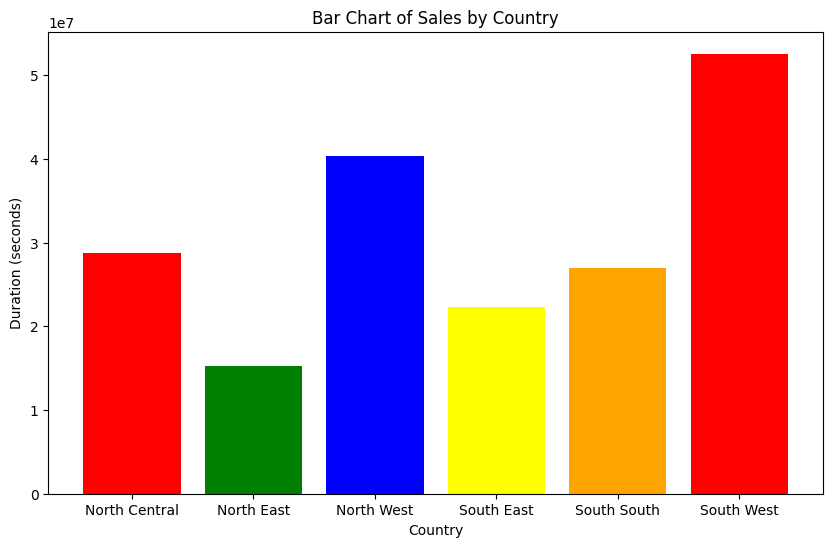

ERROR:pandasai.helpers.logger:Pipeline failed on step 6: [Errno 2] No such file or directory: 'charts/579ffb28-9290-48d1-95e5-453ea7d27f8f.png'


⚠️ No chart file found. The LLM might have failed to generate code.


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/chat/code_execution.py", line 133, in execute
    {"content_type": "response", "value": ResponseSerializer.serialize(result)},
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandasai/responses/response_serializer.py", line 35, in serialize
    with open(result["value"], "rb") as image_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'charts/

In [11]:
from pandasai import Agent

# 1. Update the Config for Charting
llm.config = {
    "llm": llm,
    "save_charts": True,  # Saves the chart as a .png file
    "save_charts_path": "./charts", # Where to save them
    "open_charts": False, # DISABLES popup (Crucial for Colab to prevent errors)
}

# 2. Initialize Agent
agent = Agent(df, config=llm.config)

# 3. Generate the Chart
response = agent.chat("Plot a bar chart of Sales by Country. Use different colors.")

# 4. Display the Chart in Colab (Manual Fail-safe)
# Sometimes PandasAI hides the chart, so we manually find and show it
import glob
from IPython.display import Image, display

# Find the most recent chart generated
list_of_files = glob.glob('./charts/*.png')
if list_of_files:
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"📊 Displaying: {latest_file}")
    display(Image(filename=latest_file))
else:
    print("⚠️ No chart file found. The LLM might have failed to generate code.")

In [13]:
# 1. Check what Python thinks your data is currently
print("BEFORE fixing:")
print(df.dtypes)

# 2. Force conversion of numeric columns
# 'coerce' means: "If you find a weird value like 'Thirty', turn it into NaN (Empty) instead of crashing"
columns_to_fix = ['ages', 'adjusted_csat', 'duration_min'] # Add any other number columns here

for col in columns_to_fix:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Verify the fix
print("\nAFTER fixing (Should say 'int64' or 'float64'):")
print(df.dtypes)

BEFORE fixing:
session_id                                 str
session_start                   datetime64[ns]
session_end                     datetime64[ns]
duration_seconds                         int64
customer_id                                str
operator                                   str
channel                                    str
intent                                     str
handled_by                                 str
escalated_to_human                        bool
message_count                            int64
resolved                                  bool
customer_satisfaction                    int64
language                                   str
sex                                        str
age                                      int64
zone                                       str
month                                    int64
direct_to_human                           bool
conversation_text                          str
sentiment                                  st

In [15]:
agent.chat("Plot a bar chart showing the average 'age' by 'intent'. Use numeric_only=True for calculations")

'charts/29702023-00d9-4ca6-8750-42c42ba8b747.png'

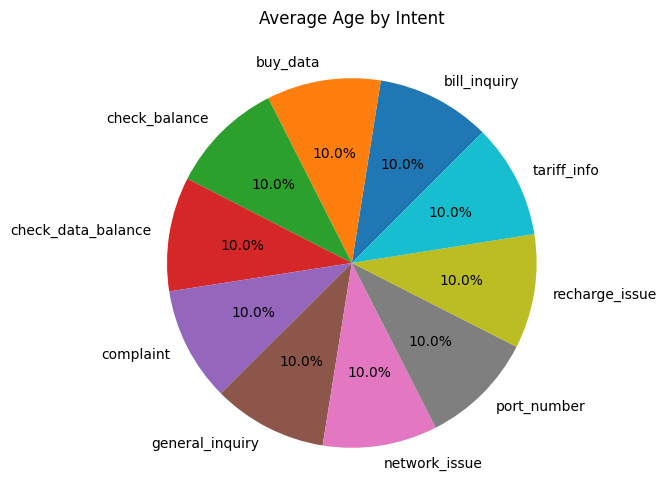

'charts/9c4985a2-4090-4e53-8097-a86378db2fbb.png'

<Figure size 640x480 with 0 Axes>

In [16]:
agent.chat("Plot average age by intent. Rotate the x-axis labels by 45 degrees to prevent overlap.")

In [18]:
# We explicitly demand a "Bar Chart" so it stops making Pie Charts
agent.chat("""
Plot a bar chart of average age by intent using PLOTLY.
Make it interactive.
Ensure you handle the figure display correctly.
""")

ERROR:pandasai.helpers.logger:Pipeline failed on step 6: [Errno 2] No such file or directory: 'interactive_bar_chart'
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandasai/pipelines/chat/code_execution.py", line 133, in execute
    {"content_type": "response", "value": ResponseSerializer.serialize(result)},
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandasai/responses/response_serializer.py", line 35, in serialize
    with open(result["value"], "rb"

"Unfortunately, I was not able to answer your question, because of the following error:\n\n[Errno 2] No such file or directory: 'interactive_bar_chart'\n"